In [ ]:
'''
env: pc3
'''

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import torch.nn.functional as F
import torch.nn as nn
import cv2
from torch.optim import lr_scheduler

from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
if torch.cuda.is_available():
     torch.set_default_tensor_type(torch.cuda.FloatTensor)

/home/cvig/anaconda3/envs/pc3/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1694763734565/work/torch/csrc/tensor/python_tensor.cpp:450.)
  _C._set_default_tensor_type(t)


In [4]:
# min_xyz = -5
# max_xyz = 5
min_xyz = torch.tensor(-3.5, dtype=torch.float32, device=device)
max_xyz = torch.tensor(3.5, dtype=torch.float32, device=device)
axis_len = max_xyz - min_xyz
axis_num_pts = 150
x = torch.linspace(min_xyz, max_xyz, axis_num_pts, device=device)
y = torch.linspace(min_xyz, max_xyz, axis_num_pts, device=device)
z = torch.linspace(min_xyz, max_xyz, axis_num_pts, device=device)
X, Y, Z = torch.meshgrid(x, y, z)
stacked_tensor = torch.stack([X, Y, Z], dim=3).to(device)
reshaped_tensor = torch.reshape(stacked_tensor, (-1, 3)).to(device)

/home/cvig/anaconda3/envs/pc3/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1694763734565/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
print(reshaped_tensor)

tensor([[-3.5000, -3.5000, -3.5000],
        [-3.5000, -3.5000, -3.4530],
        [-3.5000, -3.5000, -3.4060],
        ...,
        [ 3.5000,  3.5000,  3.4060],
        [ 3.5000,  3.5000,  3.4530],
        [ 3.5000,  3.5000,  3.5000]])


In [6]:
def rotate_xyz(p, angles):
    '''
    Reference: http://www.songho.ca/opengl/gl_anglestoaxes.html
    '''
    p = p.to(device)
    angles = angles.to(device)
    θx, θy, θz = angles
    # θx = torch.FloatTensor([θx * 3.14159 / 180.0], device=device)
    # θy = torch.FloatTensor([θy * 3.14159 / 180.0], device=device)
    # θz = torch.FloatTensor([θz * 3.14159 / 180.0], device=device)
    θx = torch.tensor([θx * 3.14159 / 180.0], device=device)
    θy = torch.tensor([θy * 3.14159 / 180.0], device=device)
    θz = torch.tensor([θz * 3.14159 / 180.0], device=device)
    R_zyx = torch.tensor([ 
        [torch.cos(θz)*torch.cos(θy), -torch.sin(θz)*torch.cos(θx) + torch.cos(θz)*torch.sin(θy)*torch.sin(θx), torch.sin(θz)*torch.sin(θx)+torch.cos(θz)*torch.sin(θy)*torch.cos(θx)],
        [torch.sin(θz)*torch.cos(θy), torch.cos(θz)*torch.cos(θx)+torch.sin(θz)*torch.sin(θy)*torch.sin(θx), -torch.cos(θz)*torch.sin(θx)+torch.sin(θz)*torch.sin(θy)*torch.cos(θx)],
        [-torch.sin(θy), torch.cos(θy)*torch.sin(θx), torch.cos(θy)*torch.cos(θx)]
    ], device=device)
    return torch.matmul(p, R_zyx.T)

# Sphere

In [7]:
def sdf_sphere(p, r, center, angles):
    # p = p.to(device)
    # r = r.to(device)
    # center = center.to(device)
    # angles = angles.to(device)
    p_rotated = rotate_xyz(p, angles)
    return torch.sqrt(torch.sum((p_rotated - center)**2, dim=1)) - r

In [ ]:
r=1
center = torch.tensor([1, 1, 1], device=device)
angles = torch.tensor([0, 0, 0], device=device)
sphere1_signed_distances_vec = sdf_sphere(reshaped_tensor, r, center, angles)
# occupancy_vec = ()

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Get the indices of the nonzero elements in the occupancy_vec tensor
# ax.scatter(reshaped_tensor[sphere1_signed_distances_vec <= 0, 0], reshaped_tensor[sphere1_signed_distances_vec <= 0,1], reshaped_tensor[sphere1_signed_distances_vec <= 0, 2], c='blue', marker='o')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# # ax.view_init(elev=30, azim=100)
# plt.show()

# Move the tensors to CPU and convert to NumPy arrays
sphere1_signed_distances_np = sphere1_signed_distances_vec.cpu().numpy()
reshaped_tensor_np = reshaped_tensor.cpu().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get the indices of the nonzero elements in the occupancy_vec tensor
ax.scatter(
    reshaped_tensor_np[sphere1_signed_distances_np <= 0, 0],
    reshaped_tensor_np[sphere1_signed_distances_np <= 0, 1],
    reshaped_tensor_np[sphere1_signed_distances_np <= 0, 2],
    c='blue',
    marker='o'
)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

# Box

In [ ]:
def sdBox(p, b, center, angles):
    '''
    p = point to be tested, nx3 tensor
    b = half the length of box, i.e. coordinates of the corner from the center
    center = center of the box
    angles = rotation angles in degrees
    '''
    p_rotated = rotate_xyz(p, angles)
    q = torch.abs(p_rotated-center) - b
    return torch.norm(torch.max(q, torch.tensor([0.,0.,0.])), dim=1) + torch.min(torch.max(q, dim=1)[0], torch.tensor([0.]))

In [ ]:
b = torch.tensor([1, 1, 1])
center = torch.tensor([1, 1, 1])
angles = torch.tensor([30, 0, 0])
box_signed_distances = sdBox(reshaped_tensor, b, center, angles)
# print("box_signed_distances shape:", box_signed_distances.shape)

In [ ]:
fig = plt.figure()
ax2 = fig.add_subplot(111, projection='3d')
ax2.scatter(reshaped_tensor[box_signed_distances <= 0, 0], reshaped_tensor[box_signed_distances <= 0,1], reshaped_tensor[box_signed_distances <= 0, 2], c='blue', marker='o')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
# ax.view_init(elev=30, azim=100)
plt.show()

# Torus

In [ ]:
def sdTorus(p, t, center, angles):
    '''
    p = point to be tested, nx3 tensor
    t = torus parameters as tuple (r, R)
    center = center of the torus
    angles = rotation angles in degrees
    '''
    no_points = p.shape[0]
    p = rotate_xyz(p, angles)
    p = p - center
    t = t.reshape(1,2)
    temp1 = (torch.norm(p[:, [0,2]], dim=1) - t[:, 0]).reshape(no_points, 1)
    temp2 = p[:, 1].reshape(no_points, 1)
    q = torch.cat([temp1, temp2], dim=1)
    temp3 = (torch.norm(q, dim=1)).reshape(no_points, 1) - t[:, 1]
    return temp3.squeeze()


In [ ]:
radius = torch.tensor([3,2])
center = torch.tensor([0, 0, 0]).reshape(1,3)
angles = torch.tensor([0, 0, 0])
torus_signed_distances = sdTorus(reshaped_tensor, radius, center, angles)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reshaped_tensor[torus_signed_distances <= 0, 0], reshaped_tensor[torus_signed_distances <= 0,1], reshaped_tensor[torus_signed_distances <= 0, 2], c='blue', marker='o')
ax.view_init(elev=10, azim=90)
plt.show()

# Triangular Prism

In [ ]:

def sdTriPrism(p, h, center, angles):
    '''
    p = point to be tested, nx3 tensor
    h = half height and half width of base triangle, 2-element tensor
    center = center of the triangular prism
    angles = rotation angles in degrees
    Note: The constant 0.866025 in the code is the square root of 3 divided by 2, and is used to simplify the computation of the signed distance function. The 0.866025 factor is the tangent of 60 degrees, the angle between the side face and the base of the prism.
    '''
    # rotate point
    p_rotated = rotate_xyz(p, angles)

    # translate to center
    p_translated = p_rotated - center
    
    # compute signed distance
    q = torch.abs(p_translated)   # nx3 tensor having absolute values of x, y, z coordinates of p_translated
    d = torch.max(torch.cat([q[:, [2]]-h[1], (q[:, [0]]*0.866025 + p_translated[:, [1]]*0.5), (-p_translated[:, [1]])-h[0]*0.5], dim=1), dim=1)[0]

    return d

In [ ]:
h = torch.tensor([4,4])
center = torch.tensor([0, 0, 0])
angles = torch.tensor([0, 0, 0])
triPrism_signed_distances = sdTriPrism(reshaped_tensor, h, center, angles)

In [ ]:
fig = plt.figure()
ax2 = fig.add_subplot(111, projection='3d')
ax2.scatter(reshaped_tensor[triPrism_signed_distances <= 0, 0], reshaped_tensor[triPrism_signed_distances <= 0,1], reshaped_tensor[triPrism_signed_distances <= 0, 2], c='blue', marker='o')
ax2.view_init(elev=30, azim=30)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
plt.show()

# Cone

In [ ]:
def sdCone(p, c, h, center=torch.tensor([0, 0, 0]), angles=torch.tensor([0, 0, 0])):
    '''
    c is the sin/cos of the angle, h is height. Alternatively pass q instead of (c,h), which is the point at the base in 2D q = torch.tensor([h * c[0] / c[1], -h, 0.0])
    '''
    reshape_no = p.shape[0]
    q = torch.tensor([h * c[0] / c[1], -h]).reshape(2,1)
    q_diag = torch.diag(q.squeeze())

    # Apply rotation and translation
    p_rotated = rotate_xyz(p, angles)
    p_rotated_centered = p_rotated - center

    # Concatenate norms and elem1 along the second dimension
    w = torch.cat((torch.norm(p_rotated_centered[:, [0, 2]], dim=1).unsqueeze(1), p_rotated_centered[:, 1].unsqueeze(1)), dim=1)
    
    temp2 = torch.clamp(torch.matmul(w, q) / torch.matmul(q.T, q), 0.0, 1.0).reshape(reshape_no, 1)    
    a = w - torch.matmul(torch.cat((temp2, temp2), dim=1), q_diag)

    b = w - torch.cat((q[0] * torch.clamp(w[:,0] / q[0], 0.0, 1.0).reshape(reshape_no, 1), q[1] * torch.ones(reshape_no, 1)), dim=1)

    k = torch.sign(q[1])
    d = torch.min(a[:,0] * a[:,0] + a[:,1] * a[:,1], b[:,0] * b[:,0] + b[:,1] * b[:,1])

    s = torch.max(k * (w[:, 0] * q[1] - w[:, 1] * q[0]), k * (w[:, 1] - q[1]))
    return torch.sqrt(d) * torch.sign(s)

In [ ]:
α = 45
α = torch.FloatTensor([α * 3.141592653589793 / 180])
c = torch.FloatTensor([torch.sin(α/2), torch.cos(α/2)])
h = torch.FloatTensor([3.0])
center = torch.FloatTensor([0, 0, 0])
angles = torch.FloatTensor([0, 0, 30])
cone_signed_distances = sdCone(reshaped_tensor, c, h, center, angles)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reshaped_tensor[cone_signed_distances <= 0, 0], reshaped_tensor[cone_signed_distances <= 0,1], reshaped_tensor[cone_signed_distances <= 0, 2], c='blue', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=120, azim=-90)
plt.show()

# Hexagonal Prism

In [ ]:
def sdHexPrism(p, h, center, angles):
    p = rotate_xyz(p, angles)
    p = p - center
    no_point = p.shape[0]
    k = torch.tensor([-0.8660254, 0.5, 0.57735]).reshape(1, 3)
    p = torch.abs(p)
    
    min_dot = torch.min(k[0,0]*p[:, 0] + k[0,1]*p[:, 1], torch.tensor(0.0)).reshape(no_point, 1)
    p[:, :2] -= 2.0 * torch.matmul(min_dot, k[0, :2].reshape(1, 2))

    d1 = torch.norm(p[:, :2] - torch.clamp(p[:, 0:2], -k[0, 2] * h[0], k[0,2] * h[0]), dim=1) * torch.sign(p[:, 1] - h[0])
    d2 = p[:, 2] - h[1]
    d = torch.stack((d1, d2), dim=1)
    return torch.min(torch.max(d[:, 0], d[:, 1]), torch.tensor(0.0)) + torch.norm(torch.max(d, torch.tensor(0.0)), dim=1)

In [ ]:
h = torch.FloatTensor([1.0,4.0])
center = torch.FloatTensor([0, 0, 0])
angles = torch.FloatTensor([90, 0, 90])
# p = torch.FloatTensor([[1, 1, 1], [-1, -2, 2], [1, -2, 3], [1, 3, 2], [2, 1, 2], [3, 4, 5]])
hexPrism_signed_distances = sdHexPrism(reshaped_tensor, h, center, angles)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reshaped_tensor[hexPrism_signed_distances <= 0, 0], reshaped_tensor[hexPrism_signed_distances <= 0,1], reshaped_tensor[hexPrism_signed_distances <= 0, 2], c='blue', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.view_init(elev=45, azim=45)
plt.show()

# Capsule

In [ ]:
def sdCapsule(p, a, b, r, center, angles):
    """
    Calculates the signed distance of a point or points to a capsule defined by two end points (a, b) and a radius (r).
    
    Arguments:
    p -- a tensor of size (n, 3) representing the point(s) to calculate the signed distance for
    a -- a tensor of size (3,) representing the first end point of the capsule
    b -- a tensor of size (3,) representing the second end point of the capsule
    r -- a float representing the radius of the capsule
    
    Returns:
    A 1D tensor of size (n,) representing the signed distance(s) of the point(s) to the capsule
    """
    # rotate point
    p = rotate_xyz(p, angles)
    # translate point
    p = p - center

    no_points = p.shape[0]
    a = a.expand(no_points, -1)  # -1 means expand along that dimension
    b = b.expand(no_points, -1)
    r = r.expand(no_points, -1)
    pa = p - a
    ba = b - a
    h = torch.clamp(torch.sum(pa * ba, dim=1) / torch.sum(ba * ba, dim = 1), 0, 1).reshape(no_points, 1)
    return (torch.norm(pa - ba * h, dim=1).reshape(no_points, 1) - r).squeeze()

In [ ]:
a = torch.FloatTensor([0,0, 3])
b = torch.FloatTensor([0,0, -3])
r = torch.FloatTensor([2])
center = torch.FloatTensor([2, 0, 0])
angles = torch.FloatTensor([30, 0, 0])
capsule_signed_distances = sdCapsule(reshaped_tensor, a, b, r, center, angles)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reshaped_tensor[capsule_signed_distances <= 0, 0], reshaped_tensor[capsule_signed_distances <= 0,1], reshaped_tensor[capsule_signed_distances <= 0, 2], c='blue', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev=30, azim=10)
plt.show()

# Verticle Capsule

In [ ]:
def sdCapsule2(p, h, r, center, angles):
    no_points = p.shape[0]
    r = r.expand(no_points, -1)

    # rotate point
    p = rotate_xyz(p, angles)
    # translate point
    p = p - center

    p[:,1] -= torch.clamp(p[:,1], torch.FloatTensor([0]), h)
    return (torch.norm(p, dim=1).reshape(no_points,1) - r).squeeze()

In [ ]:
h = torch.FloatTensor([5])
r = torch.FloatTensor([3])
center = torch.FloatTensor([0, 0, 0])
angles = torch.FloatTensor([0, 0, 0])
capsule_signed_distances2 = sdCapsule2(reshaped_tensor, h, r, center, angles)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reshaped_tensor[capsule_signed_distances2 <= 0, 0], reshaped_tensor[capsule_signed_distances2 <= 0,1], reshaped_tensor[capsule_signed_distances2 <= 0, 2], c='blue', marker='o')
# ax.view_init(elev= 20, azim=0)
plt.show()


# Octahedron - bound (not exact)

In [ ]:
def sdOctahedron(p, s, center, angles):
    '''
    s = size of the octahedron
    Constant 0.57735027 = 1/sqrt(3). This scaling factor is necessary to ensure that the distance function is normalized, meaning that the distance at the surface of the shape is equal to 1.
    '''
    no_points = p.shape[0]
    # rotate point
    p = rotate_xyz(p, angles)
    # translate point
    p = p - center

    q = torch.abs(p)
    return (q[:,0] + q[:,1] + q[:,2] - s)*0.57735027

In [ ]:
s = torch.FloatTensor([3])
center = torch.FloatTensor([0, 0, 0])
angles = torch.FloatTensor([0, 0, 0])
octahedron_signed_distances = sdOctahedron(reshaped_tensor, s, center, angles)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reshaped_tensor[octahedron_signed_distances <= 0, 0], reshaped_tensor[octahedron_signed_distances <= 0,1], reshaped_tensor[octahedron_signed_distances <= 0, 2], c='blue', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev= 30, azim=30)
plt.show()

# Ellipsoid - bound (not exact!)

In [ ]:
def sdEllipsoid(p, r, center, angles):
    '''
    r: 3D vector r that specifies the radii of the ellipsoid along each axis

    '''
    no_points = p.shape[0]
    # rotate point
    p = rotate_xyz(p, angles)
    # translate point
    p = p - center

    r = torch.reshape(r, (1,3))
    k0 = torch.norm(p/r, dim=1).reshape(no_points, 1)
    k1 = torch.norm(p/(r*r), dim=1).reshape(no_points, 1)
    return (k0*(k0-1)/k1).squeeze()

In [ ]:
r = torch.FloatTensor([3, 1.5, 0.5])
center = torch.FloatTensor([0, 0, 0])
angles = torch.FloatTensor([0, 0, 0])
ellipsoid_signed_distances = sdEllipsoid(reshaped_tensor, r, center, angles)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reshaped_tensor[ellipsoid_signed_distances <= 0, 0], reshaped_tensor[ellipsoid_signed_distances <= 0,1], reshaped_tensor[ellipsoid_signed_distances <= 0, 2], c='blue', marker='o')
# ax.view_init(elev= 0, azim=0)
plt.show()

# Link - exact 

In [ ]:
def sdLink(p, le, r1, r2, center, angles):
    '''
    le: link length
    r1: radius of the first cylinder
    r2: radius of the second cylinder
    '''
    no_points = p.shape[0]
    p = rotate_xyz(p, angles)
    p = p - center
    t1 = torch.max(torch.abs(p[:,1]).unsqueeze(1) -le, torch.tensor([0.0]))              
    q = torch.cat((p[:, 0].unsqueeze(1), t1, p[:,2].unsqueeze(1)), dim=1)
    t2 = torch.norm(q[:, 0:2], dim=1).reshape(no_points, 1) - r1
    t3 = torch.cat((t2, q[:, 2].unsqueeze(1)), dim = 1)
    temp2 = torch.norm(t3, dim=1).reshape(no_points, 1) - r2
    return temp2.squeeze()

In [ ]:
le = torch.FloatTensor([2])
r1 = torch.FloatTensor([1.5])
r2 = torch.FloatTensor([1])
center = torch.FloatTensor([0, 0, 0])
angles = torch.FloatTensor([0, 0, 0])
p = torch.FloatTensor([[1,2,3], [4,-0.5,6], [7,8,9], [10,11,12]])
link_signed_distances = sdLink(reshaped_tensor, le, r1, r2, center, angles)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reshaped_tensor[link_signed_distances <= 0, 0], reshaped_tensor[link_signed_distances <= 0,1], reshaped_tensor[link_signed_distances <= 0, 2], c='blue', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(elev= 80, azim=10)
plt.show()

# SDF Scene

In [8]:
def sdScene(parameters):
    '''
    input:
    parameters: num_shapesx6 tensor of parameters for the num_shapes shapes in the scene

    return:
    final_signed_distances: list of signed distances having shape (num_shapes, no_points)
    '''
    final_signed_distances = []
    num_shapes = parameters.shape[0]

    # Iterate over each shape in the parameters tensor
    for i in range(num_shapes):
        r = 0.3
        center = parameters[i, 0:3]
        angles = parameters[i, 3:6]
        sphere_signed_distances = sdf_sphere(reshaped_tensor, r, center, angles)
        final_signed_distances.append(sphere_signed_distances)

    stacked_final_signed_distances = torch.stack(final_signed_distances, dim=1)  
    return num_shapes, stacked_final_signed_distances

In [9]:
def define_shape(points_2d):
    '''
    returns: (points_2d x 1) tensor having values 1 if the point is inside the triangle and 0 otherwise
    '''
    vertices = [(0.5, 0.5), (0.5, 4), (3, 2)]

    # Create a Path object from the vertices
    triangle = Path(vertices)
    print("points_2d inside define_shape: ", points_2d)
    points_2d_cpu = points_2d.to('cpu')
    points_2d = points_2d_cpu.numpy()
    # Check if each point is inside or outside the triangle
    inside = triangle.contains_points(points_2d)

    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # ax.scatter(points_2d.loc[inside > 0, 0], points_2d.loc[inside > 0,1], c='blue', marker='o')
    # # ax.view_init(elev= 80, azim=10)
    # plt.show()

    inside = inside.astype(np.float32)
    inside = torch.tensor(inside, dtype=torch.float32, device=device)

    return inside

In [10]:
def define_shape_V(points_2d):
    '''
    returns: (points_2d x 1) tensor having values 1 if the point is inside the triangle and 0 otherwise
    '''

    # Define the vertices of the triangle
    # vertices = [(-6, -6), (6, 0), (0, 6)]
    # vertices = [(-4, 4), (4, 4), (0, -4)]
    vertices = [(0.5, 4), (1, 4), (1.5, 1.5), (2,4), (2.5, 4), (2, 0.5), (1, 0.5)]

    # Create a Path object from the vertices
    triangle = Path(vertices)
    print("points_2d inside define_shape_V: ", points_2d)
    points_2d_cpu = points_2d.to('cpu')
    points_2d = points_2d_cpu.numpy()
    # Check if each point is inside or outside the triangle
    inside = triangle.contains_points(points_2d)

    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # ax.scatter(points_2d.loc[inside > 0, 0], points_2d.loc[inside > 0,1], c='blue', marker='o')
    # # ax.view_init(elev= 80, azim=10)
    # plt.show()

    inside = inside.astype(np.float32)
    inside = torch.tensor(inside, dtype=torch.float32, device=device)

    return inside

In [11]:
def load_image_and_convert_to_tensor(image_path, target_size=(30, 30)):
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    print(image.shape)

    # Display the image in a window
    # cv2_imshow(image)
    # cv2.imshow("Image", image)
    # Wait for a key press and then close the window
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    if image is None:
        # If no image is loaded, return a tensor with 0
        print('Images is None!')
        return np.zeros(target_size, dtype=np.uint8)

    # Resize the image to the target size
    image = cv2.resize(image, target_size)
    # print('image: ', image)
    # Convert the image to grayscale if it's not already
    if len(image.shape) == 3 and image.shape[2] == 3:
        print('It is a 3D image, converting to black and white!')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Convert the grayscale image to a binary tensor
    # binary_tensor = (image > 0).astype(np.uint8)
    binary_tensor = torch.tensor((image < 1).astype(np.uint8))

    # make it such that it is compatible the points in 2D: e.g., (-4, -4), (-4, -3.5), (-4, -3), ..., (4, 3.5), (4, 4)
    reversed_tensor = torch.flip(binary_tensor, [0])        # Reverse the rows
    reversed_tensor = torch.transpose(reversed_tensor, 0, 1)
    result_tensor = reversed_tensor.reshape(-1)

    return result_tensor

In [12]:
point_xy = reshaped_tensor[:, 0:2]
point_xy = torch.unique(point_xy, dim=0)
point_xy = point_xy.to(device)
print("point_xy: ", point_xy)
print("point_xy shape:", point_xy.shape)
point_xy_union = torch.cat([point_xy, torch.zeros(point_xy.shape[0], 1, device=device)], dim=1)
print("point_xy_union:", point_xy_union)
print("point_xy_union shape:", point_xy_union.shape)

point_xy:  tensor([[-3.5000, -3.5000],
        [-3.5000, -3.4530],
        [-3.5000, -3.4060],
        ...,
        [ 3.5000,  3.4060],
        [ 3.5000,  3.4530],
        [ 3.5000,  3.5000]])
point_xy shape: torch.Size([22500, 2])
point_xy_union: tensor([[-3.5000, -3.5000,  0.0000],
        [-3.5000, -3.4530,  0.0000],
        [-3.5000, -3.4060,  0.0000],
        ...,
        [ 3.5000,  3.4060,  0.0000],
        [ 3.5000,  3.4530,  0.0000],
        [ 3.5000,  3.5000,  0.0000]])
point_xy_union shape: torch.Size([22500, 3])


In [13]:
# Defining Triangular shape
inside = define_shape(point_xy)
inside = inside.to(device)
print("inside.shape: ", inside.shape)
pts_inside = torch.cat([point_xy, inside.reshape(point_xy.shape[0], 1)], dim=1)
print("pts_inside.shape: ", pts_inside.shape)

print(inside)
print(inside.sum())

points_2d inside define_shape:  tensor([[-3.5000, -3.5000],
        [-3.5000, -3.4530],
        [-3.5000, -3.4060],
        ...,
        [ 3.5000,  3.4060],
        [ 3.5000,  3.4530],
        [ 3.5000,  3.5000]])
inside.shape:  torch.Size([22500])
pts_inside.shape:  torch.Size([22500, 3])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor(1891.)


In [14]:
# Defining V-shape
inside_V = define_shape_V(point_xy)
inside_V = inside_V.to(device)
print("inside_V.shape: ", inside_V.shape)
pts_inside_V = torch.cat([point_xy, inside_V.reshape(point_xy.shape[0], 1)], dim=1)
print("pts_inside.shape: ", pts_inside.shape)

print(inside_V)
print(inside_V.sum())

points_2d inside define_shape_V:  tensor([[-3.5000, -3.5000],
        [-3.5000, -3.4530],
        [-3.5000, -3.4060],
        ...,
        [ 3.5000,  3.4060],
        [ 3.5000,  3.4530],
        [ 3.5000,  3.5000]])
inside_V.shape:  torch.Size([22500])
pts_inside.shape:  torch.Size([22500, 3])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor(1588.)


In [15]:
# Example usage:
image_path = "apple2.jpg"
target_size = (axis_num_pts, axis_num_pts)
apple = load_image_and_convert_to_tensor(image_path=image_path, target_size=target_size)

(995, 995, 3)
It is a 3D image, converting to black and white!


In [16]:
# Assign the required image to the variable inside
inside = apple.clone()

In [17]:
def plot_union(parameters):
    num_shapes, stacked_final_signed_distances = sdScene(parameters)
    # union_sdf = torch.min(stacked_final_signed_distances, dim=1)[0]
    union_sdf = torch.min(stacked_final_signed_distances, dim=1)[0].to('cpu')
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    reshaped_tensor_cpu = reshaped_tensor.to('cpu')
    # ax.scatter(reshaped_tensor[union_sdf <= 0, 0], reshaped_tensor[union_sdf <= 0,1], reshaped_tensor[union_sdf <= 0, 2], c='blue', marker='o')
    ax.scatter(reshaped_tensor_cpu[union_sdf <= 0, 0], reshaped_tensor_cpu[union_sdf <= 0,1], reshaped_tensor_cpu[union_sdf <= 0, 2], c='blue', marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev= 90, azim=-90)
    plt.show()

In [18]:
def plot_intersections(parameters):
    '''
    get intersection matrix and plot intersections
    '''
    num_shapes, stacked_final_signed_distances = sdScene(parameters)
    intersection_mat = [[None for _ in range(num_shapes)] for _ in range(num_shapes)]       # creating empty list of lists of size num_shapes x num_shape
    fig = plt.figure(figsize=(10, 10))  # create a figure object
    reshaped_tensor_cpu = reshaped_tensor.to('cpu')
    for i in range(num_shapes):
        for j in range(i+1, num_shapes):
            intersection_mat[i][j] = torch.max(stacked_final_signed_distances[:, i], stacked_final_signed_distances[:, j]).to('cpu')
            ax = fig.add_subplot(num_shapes, num_shapes, i*num_shapes+j+1, projection='3d')

            ax.scatter(reshaped_tensor_cpu[intersection_mat[i][j] <= 0, 0], reshaped_tensor_cpu[intersection_mat[i][j] <= 0,1], reshaped_tensor_cpu[intersection_mat[i][j] <= 0, 2], c='blue', marker='o')
            
    # Set horizontal and vertical space between subplots
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()

In [19]:
def plot_shape(shape):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # ax.scatter(point_xy[inside > 0, 0], point_xy[inside > 0,1], c='blue', marker='o')
    point_xy_cpu = point_xy.to('cpu')
    shape_cpu = shape.to('cpu')
    ax.scatter(point_xy_cpu[shape_cpu > 0, 0], point_xy_cpu[shape_cpu > 0,1], c='blue', marker='o')
    # ax.view_init(elev= 80, azim=10)
    plt.show()
# plot_shape(shape=inside)
# plot_shape(shape=inside_V)
# plot_shape(shape=apple)

In [20]:
# Just testing
reshaped_tensor.shape[0]
axis_num_pts
inside.shape

torch.Size([22500])

In [21]:
def calulate_loss(num_shapes, stacked_final_signed_distances):
    print("inside calulate_loss, stacked_final_signed_distances.requires_grad: ", stacked_final_signed_distances.requires_grad)
    
    # Intersection Loss
    intersection_loss = 0
    intersection_mat = [[None for _ in range(num_shapes)] for _ in range(num_shapes)] # creating empty list of lists of size num_shapes x num_shape
    
    for i in range(num_shapes):
        for j in range(i+1, num_shapes):
            intersection_mat[i][j] = torch.max(stacked_final_signed_distances[:, i], stacked_final_signed_distances[:, j])
            intersection_loss += torch.sum(intersection_mat[i][j][intersection_mat[i][j] <= 0])

    intersection_loss = - intersection_loss/num_shapes
    print('Intersection Loss: ', intersection_loss)
    
    # Projection Loss
    stacked_final_signed_distances_relu = torch.relu(-stacked_final_signed_distances)
    # stacked_final_signed_distances_sigmoid = torch.sigmoid(-stacked_final_signed_distances)
    projection_loss = 0

    f = 0
    for k in range(0, reshaped_tensor.shape[0], axis_num_pts):
        # projection_loss += (stacked_final_signed_distances_relu[k:k+axis_num_pts, :].sum()/axis_num_pts - inside[f]).pow(2)

        sum_for_a_point_relu = stacked_final_signed_distances_relu[k:k+axis_num_pts, :].sum()
        projection_loss += (sum_for_a_point_relu/(sum_for_a_point_relu+0.0001) - inside[f]).pow(2)

        # sum_for_a_point_sigmoid = stacked_final_signed_distances_sigmoid[k:k+axis_num_pts, :].sum()
        # projection_loss += (sum_for_a_point_sigmoid/(sum_for_a_point_sigmoid + 1) - inside[f]).pow(2)
        f+=1
    print('Projection Loss: ', projection_loss)

    # Total Loss
    # loss = (2*intersection_loss * projection_loss) / (intersection_loss + projection_loss)
    loss = intersection_loss + projection_loss
    print('Total Loss: ', loss)
    
    return loss.float()

In [ ]:
# parameters = [[0.5,0.5,0.5,90,90,90], [0.6,0.5,0.5,100,0,10], [-2.5, -1, 2,30,20,-200], [1,2,1,50,180,0], [-1, -2, 1,35,-20,-10], [0, 0, 0,70,80,90]]
# parameters = [[0,0,0,0,0,0], [0.3,2,-0.3,0,0,0], [-0.3,-0.3,-0.3,0,0,0], [-3,1,-2,0,0,0], [3,2,0,0,0,0], [2,1,3,0,0,0]]
# parameters = [[0.5,0,0,0,0,0], [3,2,0,0,0,0], [3,1.5,0,0,0,0], [2.5,3.5,2,0,0,0], [2,3.5,2,0,0,0], [0,3.5,-3,0,0,0], [1.5,2.5,-2,0,0,0], [1,1,2,0,0,0], [1.5,1.5,2,0,0,0], [1.7,1.5,2.2,0,0,0]]
# parameters = [[0.5,0,0,0,0,0], [1.5,0.5,0,0,0,0], [3,1.5,0,0,0,0]]
# parameters = [[0.5,0.5,0,0,0,0], [3,2,0,0,0,0], [2,1,0,0,0,0], [2.5,2,2,0,0,0], [2,2,2,0,0,0], [0.5,3.5,-3,0,0,0], [1.5,2.5,-2,0,0,0], [1,1,2,0,0,0], [1.5,1.5,2,0,0,0], [1.7,1.5,2.2,0,0,0]]

# option1
# torch.manual_seed(0)
# n = 55
# x = torch.distributions.Uniform(-1, 1).sample((n, 1))
# y = torch.distributions.Uniform(-1, 1).sample((n, 1))
# z = torch.distributions.Uniform(-3, 3).sample((n, 1))
# theta_x = torch.zeros(n, 1)
# theta_y = torch.zeros(n, 1)
# theta_z = torch.zeros(n, 1)
# parameters = torch.concatenate((x, y, z, theta_x, theta_y, theta_z), axis=1)
# parameters = torch.tensor(parameters, dtype=torch.float32, requires_grad=True)

# option2
parameters = torch.tensor([[ 0.4303,  0.3751, -3.6326,  0.0000,  0.0000,  0.0000],
        [-0.0994,  0.6010,  1.7917,  0.0000,  0.0000,  0.0000],
        [-1.7502,  0.4573,  2.7560,  0.0000,  0.0000,  0.0000],
        [ 0.8331,  0.2398,  2.7938,  0.0000,  0.0000,  0.0000],
        [-0.0075,  0.0167,  0.7158,  0.0000,  0.0000,  0.0000],
        [ 1.1847,  0.2365, -0.8288,  0.0000,  0.0000,  0.0000],
        [ 0.4693,  0.5251, -0.5653,  0.0000,  0.0000,  0.0000],
        [ 1.2570,  0.3802,  0.7699,  0.0000,  0.0000,  0.0000],
        [-0.5845, -2.2095, -1.3260,  0.0000,  0.0000,  0.0000],
        [ 0.8959, -0.2761,  1.0812,  0.0000,  0.0000,  0.0000],
        [-1.5442, -1.5038, -3.4407,  0.0000,  0.0000,  0.0000],
        [-1.0790, -0.5019,  0.9582,  0.0000,  0.0000,  0.0000],
        [ 0.3752, -0.3782, -2.1640,  0.0000,  0.0000,  0.0000],
        [ 1.2650,  1.0529,  3.2820,  0.0000,  0.0000,  0.0000],
        [-1.1968, -0.8327, -3.2400,  0.0000,  0.0000,  0.0000],
        [-1.2931,  1.0490, -3.4471,  0.0000,  0.0000,  0.0000],
        [ 1.5071,  0.9219,  2.1487,  0.0000,  0.0000,  0.0000],
        [ 0.0704, -0.7565,  2.9153,  0.0000,  0.0000,  0.0000],
        [-0.7872,  0.8496, -1.9932,  0.0000,  0.0000,  0.0000],
        [-0.3387, -1.2217,  0.3725,  0.0000,  0.0000,  0.0000],
        [ 1.4653,  0.8613, -0.3392,  0.0000,  0.0000,  0.0000],
        [-1.2028,  0.9584,  1.6503,  0.0000,  0.0000,  0.0000],
        [ 0.9332,  0.8945, -1.0851,  0.0000,  0.0000,  0.0000],
        [ 0.4324,  0.9757, -1.4854,  0.0000,  0.0000,  0.0000],
        [-1.2617, -0.0868, -1.6195,  0.0000,  0.0000,  0.0000],
        [ 0.6169, -0.6344, -3.5862,  0.0000,  0.0000,  0.0000],
        [-1.8352, -0.1644, -0.5853,  0.0000,  0.0000,  0.0000],
        [-0.5257,  0.0847, -1.4231,  0.0000,  0.0000,  0.0000],
        [ 0.9127, -0.9426,  0.2531,  0.0000,  0.0000,  0.0000],
        [ 0.1725, -0.4479,  1.4399,  0.0000,  0.0000,  0.0000],
        [-0.6792, -0.4456,  2.3338,  0.0000,  0.0000,  0.0000],
        [ 0.4524,  0.6455, -2.8178,  0.0000,  0.0000,  0.0000],
        [ 1.4859, -1.1481, -0.7499,  0.0000,  0.0000,  0.0000],
        [ 1.0592,  0.4977, -2.3335,  0.0000,  0.0000,  0.0000],
        [-1.8363, -1.3041, -0.4949,  0.0000,  0.0000,  0.0000],
        [-1.4246,  0.6388, -2.6278,  0.0000,  0.0000,  0.0000],
        [ 0.7750,  1.0259,  1.3792,  0.0000,  0.0000,  0.0000],
        [ 1.1847, -1.4704,  1.3869,  0.0000,  0.0000,  0.0000],
        [-0.4613, -0.4259, -2.4992,  0.0000,  0.0000,  0.0000],
        [-0.7827, -1.4955,  3.4891,  0.0000,  0.0000,  0.0000],
        [ 0.5055,  0.0203, -1.2501,  0.0000,  0.0000,  0.0000],
        [ 0.1670, -2.2158,  0.2797,  0.0000,  0.0000,  0.0000],
        [-0.3740,  0.7360, -0.0597,  0.0000,  0.0000,  0.0000],
        [ 0.5051, -1.2422,  1.0941,  0.0000,  0.0000,  0.0000],
        [ 0.8137, -1.8560, -1.5911,  0.0000,  0.0000,  0.0000],
        [-1.2485, -1.6686,  1.7118,  0.0000,  0.0000,  0.0000],
        [ 0.3256,  0.4994,  0.1690,  0.0000,  0.0000,  0.0000],
        [-0.7813,  0.7332,  2.9359,  0.0000,  0.0000,  0.0000],
        [-0.0419, -1.7456, -2.9663,  0.0000,  0.0000,  0.0000],
        [ 0.1069, -0.2315, -0.0509,  0.0000,  0.0000,  0.0000],
        [-1.8288, -0.5886,  0.8330,  0.0000,  0.0000,  0.0000],
        [ 1.1618, -0.5787, -1.9418,  0.0000,  0.0000,  0.0000],
        [-0.6706, -0.9904, -0.8344,  0.0000,  0.0000,  0.0000],
        [ 0.8905, -2.4158, -2.2488,  0.0000,  0.0000,  0.0000],
        [-1.1063,  0.4003,  1.0606,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

# Remain same
parameters = torch.nn.Parameter(parameters)

# plot_intersections(parameters)
# plot_union(parameters)
# plot_shape(shape=apple)
lr=0.0001
optimizer = torch.optim.Adam([parameters], lr=lr)
# print(parameters.requires_grad)
print("parameters.grad: ", parameters.grad) # it will show none as we have not called backward() yet

# Define a learning rate scheduler
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
# scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)  # lr = lr * gamma after every step_size number of epochs

start_epoch = 371
end_epoch = 420
for i in range(start_epoch, end_epoch+1):
    print('Iteration: ', i)
    optimizer.zero_grad()
    num_shapes, stacked_final_signed_distances = sdScene(parameters)
    loss = calulate_loss(num_shapes, stacked_final_signed_distances)
    # loss = -calulate_loss(num_shapes, stacked_final_signed_distances)
    loss.backward()
    print('Gradients:')
    if parameters.grad is not None:
        print(parameters.grad.norm(2).item())

    print("Gradient before update:", parameters.grad.sum())
    optimizer.step()

    # Manually adjust the learning rate based on the current epoch
    # if i%15 == 0:
    #     optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] / 2  # Set the learning rate to 0.01 after 10 epochs

    # scheduler.step(loss)
    print("Gradient after update:", parameters.grad.sum())
    current_lr = optimizer.param_groups[0]['lr']
    print('current Learning Rate: ', current_lr)
    if(i%2 == 0):
        print('Total Loss: ', loss)
        print(parameters)
    print('------------------------------------------------------------------------------------------------------------------')  

# plot_intersections(parameters)
# plot_union(parameters)
# final_lr = optimizer.param_groups[0]['lr']
# print('Final Learning Rate: ', final_lr)

In [ ]:
current_lr = optimizer.param_groups[0]['lr']
print('current Learning Rate: ', current_lr)

In [25]:
# def plot_shape_and_union(parameters):
#     fig = plt.figure()
#     ax = fig.add_subplot(111)

#     # Plot the shape
#     # ax.scatter(point_xy[inside > 0, 0], point_xy[inside > 0,1], c='blue', marker='o')
#     point_xy_cpu = point_xy.to('cpu')
#     inside_cpu = inside.to('cpu')
#     ax.scatter(point_xy_cpu[inside_cpu > 0, 0], point_xy_cpu[inside_cpu > 0,1], c='blue', marker='o')
#     # ax.view_init(elev= 80, azim=10)
#     # plt.show()

#     # Plot the union
#     num_shapes, stacked_final_signed_distances = sdScene(parameters)
#     # union_sdf = torch.min(stacked_final_signed_distances, dim=1)[0]
#     union_sdf = torch.min(stacked_final_signed_distances, dim=1)[0].to('cpu')
    

#     reshaped_tensor_cpu = reshaped_tensor.to('cpu')
#     ax.scatter(reshaped_tensor_cpu[union_sdf <= 0, 0], reshaped_tensor_cpu[union_sdf <= 0,1], c='red', marker='o')
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     plt.show()

#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     reshaped_tensor_cpu = reshaped_tensor.to('cpu')
#     ax.scatter(reshaped_tensor_cpu[union_sdf <= 0, 0], reshaped_tensor_cpu[union_sdf <= 0,1], reshaped_tensor_cpu[union_sdf <= 0, 2], c='red', marker='o')
#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     ax.view_init(elev= 90, azim=-90)
#     plt.show()

def plot_shape_and_union(parameters):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Plot the shape
    # ax.scatter(point_xy[inside > 0, 0], point_xy[inside > 0,1], c='blue', marker='o')
    point_xy_cpu = point_xy.to('cpu')
    inside_cpu = inside.to('cpu')
    # ax.scatter(point_xy_cpu[inside_cpu > 0, 0], point_xy_cpu[inside_cpu > 0,1], c='blue', marker='o')
    # ax.view_init(elev= 80, azim=10)
    # plt.show()

    # Plot the union
    num_shapes, stacked_final_signed_distances = sdScene(parameters)
    # union_sdf = torch.min(stacked_final_signed_distances, dim=1)[0]
    union_sdf = torch.min(stacked_final_signed_distances, dim=1)[0].to('cpu')
    

    reshaped_tensor_cpu = reshaped_tensor.to('cpu')
    ax.scatter(reshaped_tensor_cpu[:, 0], reshaped_tensor_cpu[:,1], c='black', marker='o')
    ax.scatter(reshaped_tensor_cpu[union_sdf <= 0, 0], reshaped_tensor_cpu[union_sdf <= 0,1], c='white', marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    reshaped_tensor_cpu = reshaped_tensor.to('cpu')
    ax.scatter(reshaped_tensor_cpu[union_sdf <= 0, 0], reshaped_tensor_cpu[union_sdf <= 0,1], reshaped_tensor_cpu[union_sdf <= 0, 2], c='red', marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(elev= 90, azim=-90)
    plt.show()

In [ ]:
def plot_shape_and_union_black_white(parameters):
    # fig = plt.figure()###
    # ax = fig.add_subplot(111)       ###

    # Plot the shape
    # ax.scatter(point_xy[inside > 0, 0], point_xy[inside > 0,1], c='blue', marker='o')
    point_xy_cpu = point_xy.to('cpu')
    inside_cpu = inside.to('cpu')
    # ax.scatter(point_xy_cpu[inside_cpu > 0, 0], point_xy_cpu[inside_cpu > 0,1], c='blue', marker='o')   ###
    # ax.view_init(elev= 80, azim=10)
    # plt.show()

    # Plot the union
    num_shapes, stacked_final_signed_distances = sdScene(parameters)
    print('stacked_final_signed_distances.sum(): ', stacked_final_signed_distances.sum())
    union_2d = torch.zeros(axis_num_pts*axis_num_pts, dtype=torch.float32)
    # union_2d = torch.zeros(axis_num_pts*axis_num_pts, dtype=torch.float32)
    # union_2d = union_2d*1.0
    j = 0
    for i in range(0, stacked_final_signed_distances.shape[0], axis_num_pts):
        # temp = stacked_final_signed_distances[i:i+axis_num_pts, :]
        union_2d[j] = 0 if (stacked_final_signed_distances[i:i+axis_num_pts, :].min() <= 0) else 1
        j += 1
    print("point_xy_cpu.shape: ", point_xy_cpu.shape)   # [n^2, 2]
    print("union_2d.shape: ", union_2d.shape)           # [n^2]
    print('union_2d.sum(): ', union_2d.sum())

    union_2d = union_2d.to('cpu')
    # Concatenate coordinates and values along the second dimension
    # x_y_and_union = torch.cat((point_xy_cpu, union_2d.unsqueeze(1)), dim=1)
    # Visualize the tensor as a black and white image
    # x_y_and_union_array = x_y_and_union.numpy()
    # Create a binary image using values (assuming values are 1 and 0)
    binary_image = union_2d.reshape(-1, 1).to('cpu')
    print('binary_image.shape: ', binary_image.shape)   # [n^2, 1]
    # Reshape coordinates into the shape of the image
    image_shape = (axis_num_pts, axis_num_pts)          # You can adjust the shape based on your data
    # image_shape = (8, 8)          # You can adjust the shape based on your data
    coordinates = point_xy_cpu.clone().detach()

    coordinates[:,0] = coordinates[:,0] + abs(coordinates[:,0].min())
    coordinates[:,1] = coordinates[:,1] + abs(coordinates[:,1].min())
    print('coordinates[:,0].min: ', coordinates[:,0].min())
    print('coordinates[:,1].min: ', coordinates[:,1].min())
    print('coordinates[:,0].max: ', coordinates[:,0].max())
    print('coordinates[:,1].max: ', coordinates[:,1].max())

    coordinates[:, 0] = ((point_xy_cpu[:, 0] - point_xy_cpu[:, 0].min()) / (point_xy_cpu[:, 0].max() - point_xy_cpu[:, 0].min())) * (image_shape[0] - 1)
    coordinates[:, 1] = ((point_xy_cpu[:, 1] - point_xy_cpu[:, 1].min()) / (point_xy_cpu[:, 1].max() - point_xy_cpu[:, 1].min())) * (image_shape[1] - 1)
    # coordinates = coordinates.round().astype(int)
    coordinates = coordinates.round().to(torch.int32)

    # Create an empty black image
    image = torch.zeros(image_shape).to('cpu')
    # print("coordinates.device: ", coordinates.device)

    # Set values in the image based on the coordinates and values
    # image[coordinates[:, 0], coordinates[:, 1]] = torch.tensor(binary_image.squeeze(), dtype=torch.float32)
    image[coordinates[:, 0], coordinates[:, 1]] = binary_image.squeeze().clone().detach()

    # Display the image
    plt.imshow(image.numpy(), cmap='gray')
    # plt.imshow(image.numpy())
    plt.show()

# point_xy_cpu.shape:  torch.Size([2500, 2])
# union_2d.shape:  torch.Size([2500])
# binary_image.shape:  torch.Size([2500, 1])


    # # union_sdf = torch.min(stacked_final_signed_distances, dim=1)[0]
    # union_sdf = torch.min(stacked_final_signed_distances, dim=1)[0].to('cpu')
    # # print("union_sdf.shape: ", union_sdf.shape)

    # reshaped_tensor_cpu = reshaped_tensor.to('cpu')
    # ax.scatter(reshaped_tensor_cpu[union_sdf <= 0, 0], reshaped_tensor_cpu[union_sdf <= 0,1], c='red', marker='o')
    # ax.set_xlabel('X')
    # ax.set_ylabel('Y')
    # plt.show()

    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # reshaped_tensor_cpu = reshaped_tensor.to('cpu')
    # ax.scatter(reshaped_tensor_cpu[union_sdf <= 0, 0], reshaped_tensor_cpu[union_sdf <= 0,1], reshaped_tensor_cpu[union_sdf <= 0, 2], c='red', marker='o')
    # ax.set_xlabel('X')
    # ax.set_ylabel('Y')
    # ax.set_zlabel('Z')
    # ax.view_init(elev= 90, azim=-90)
    # plt.show()

In [ ]:
# tempo = torch.tensor(1.499)
# tempo = tempo.round().to(torch.int32)
# tempo

In [ ]:
grid_area = axis_num_pts*axis_num_pts
shape_area =  inside.sum()
fraction = shape_area/grid_area
grid_actual_area = (max_xyz - min_xyz) * (max_xyz - min_xyz)
shape_actual_area = fraction * (max_xyz - min_xyz) * (max_xyz - min_xyz)
print("grid_actual_area: ", grid_actual_area)
print("shape_actual_area: ", shape_actual_area)
radius_circle = 0.37
circle_area = torch.pi * radius_circle * radius_circle
num_sheres_needed = shape_actual_area/circle_area
print("num_sheres_needed: ", num_sheres_needed)

In [26]:
final_parameters = torch.tensor([[ 0.4257,  0.3704, -3.6278,  0.0000,  0.0000,  0.0000],
        [-0.0951,  0.6054,  1.7917,  0.0000,  0.0000,  0.0000],
        [-1.7541,  0.4589,  2.7603,  0.0000,  0.0000,  0.0000],
        [ 0.8336,  0.2351,  2.7932,  0.0000,  0.0000,  0.0000],
        [-0.0126,  0.0218,  0.7137,  0.0000,  0.0000,  0.0000],
        [ 1.1885,  0.2327, -0.8269,  0.0000,  0.0000,  0.0000],
        [ 0.4696,  0.5249, -0.5655,  0.0000,  0.0000,  0.0000],
        [ 1.2609,  0.3763,  0.7730,  0.0000,  0.0000,  0.0000],
        [-0.5864, -2.2122, -1.3221,  0.0000,  0.0000,  0.0000],
        [ 0.9005, -0.2715,  1.0835,  0.0000,  0.0000,  0.0000],
        [-1.5409, -1.5082, -3.4455,  0.0000,  0.0000,  0.0000], #
        [-1.0838, -0.4972,  0.9583,  0.0000,  0.0000,  0.0000],
        [ 0.3802, -0.3832, -2.1623,  0.0000,  0.0000,  0.0000],
        [ 1.2682,  1.0562,  3.2851,  0.0000,  0.0000,  0.0000],
        [-1.2004, -0.8358, -3.2367,  0.0000,  0.0000,  0.0000],
        [-1.2933,  1.0466, -3.4522,  0.0000,  0.0000,  0.0000],
        [ 1.5117,  0.9264,  2.1443,  0.0000,  0.0000,  0.0000],
        [ 0.0662, -0.7614,  2.9166,  0.0000,  0.0000,  0.0000],
        [-0.7842,  0.8526, -1.9961,  0.0000,  0.0000,  0.0000],
        [-0.3340, -1.2245,  0.3715,  0.0000,  0.0000,  0.0000],
        [ 1.4680,  0.8586, -0.3368,  0.0000,  0.0000,  0.0000],
        [-1.1979,  0.9633,  1.6455,  0.0000,  0.0000,  0.0000],
        [ 0.9383,  0.8994, -1.0801,  0.0000,  0.0000,  0.0000],
        [ 0.4317,  0.9764, -1.4863,  0.0000,  0.0000,  0.0000],
        [-1.2600, -0.0851, -1.6201,  0.0000,  0.0000,  0.0000],
        [ 0.6120, -0.6393, -3.5813,  0.0000,  0.0000,  0.0000],
        [-1.8399, -0.1605, -0.5832,  0.0000,  0.0000,  0.0000],
        [-0.5305,  0.0880, -1.4242,  0.0000,  0.0000,  0.0000],
        [ 0.9133, -0.9477,  0.2529,  0.0000,  0.0000,  0.0000],
        [ 0.1677, -0.4528,  1.4374,  0.0000,  0.0000,  0.0000],
        [-0.6845, -0.4403,  2.3325,  0.0000,  0.0000,  0.0000],
        [ 0.4477,  0.6503, -2.8156,  0.0000,  0.0000,  0.0000],
        [ 1.4898, -1.1518, -0.7500,  0.0000,  0.0000,  0.0000],
        [ 1.0545,  0.5025, -2.3334,  0.0000,  0.0000,  0.0000],
        [-1.8372, -1.3041, -0.4980,  0.0000,  0.0000,  0.0000],
        [-1.4290,  0.6432, -2.6259,  0.0000,  0.0000,  0.0000],
        [ 0.7780,  1.0291,  1.3765,  0.0000,  0.0000,  0.0000],
        [ 1.1883, -1.4740,  1.3835,  0.0000,  0.0000,  0.0000],
        [-0.4566, -0.4306, -2.4999,  0.0000,  0.0000,  0.0000],
        [-0.7856, -1.4929,  3.4847,  0.0000,  0.0000,  0.0000],
        [ 0.5037,  0.0158, -1.2501,  0.0000,  0.0000,  0.0000],
        [ 0.1672, -2.2166,  0.2844,  0.0000,  0.0000,  0.0000],
        [-0.3709,  0.7391, -0.0567,  0.0000,  0.0000,  0.0000],
        [ 0.5007, -1.2465,  1.0899,  0.0000,  0.0000,  0.0000],
        [ 0.8107, -1.8533, -1.5883,  0.0000,  0.0000,  0.0000],
        [-1.2470, -1.6732,  1.7080,  0.0000,  0.0000,  0.0000],
        [ 0.3207,  0.4945,  0.1682,  0.0000,  0.0000,  0.0000],
        [-0.7764,  0.7282,  2.9366,  0.0000,  0.0000,  0.0000],
        [-0.0416, -1.7488, -2.9618,  0.0000,  0.0000,  0.0000],
        [ 0.1020, -0.2357, -0.0511,  0.0000,  0.0000,  0.0000],
        [-1.8330, -0.5896,  0.8334,  0.0000,  0.0000,  0.0000],
        [ 1.1665, -0.5761, -1.9383,  0.0000,  0.0000,  0.0000],
        [-0.6662, -0.9933, -0.8334,  0.0000,  0.0000,  0.0000],
        [ 0.8896, -2.4111, -2.2500,  0.0000,  0.0000,  0.0000],
        [-1.1020,  0.3959,  1.0566,  0.0000,  0.0000,  0.0000],

        [-1,  -2.5,  1.0566,  0.0000,  0.0000,  0.0000],
        [-1.5, -2,  1.0566,  0.0000,  0.0000,  0.0000],
        [-1,  -2,  1.0566,  0.0000,  0.0000,  0.0000],
        [-2,  0,  1.0566,  0.0000,  0.0000,  0.0000],
        [-2,  -0.5,  1.0566,  0.0000,  0.0000,  0.0000],
        [-0.5,  1.1,  1.0566,  0.0000,  0.0000,  0.0000],
        [-0.2,  -2.3,  1.0566,  0.0000,  0.0000,  0.0000],
        [-0.8,  -2.6,  1.0566,  0.0000,  0.0000,  0.0000],
        [-1.6,  1,  1.0566,  0.0000,  0.0000,  0.0000],
        [-0.95,  1.1,  1.0566,  0.0000,  0.0000,  0.0000],

        [1.5,  -2.2,  1.0566,  0.0000,  0.0000,  0.0000],
        [2,  -1.6,  1.0566,  0.0000,  0.0000,  0.0000],
        [1.6,  -2,  1.0566,  0.0000,  0.0000,  0.0000],
        [1.3,  0,  1.0566,  0.0000,  0.0000,  0.0000],
        [1.8,  1,  1.0566,  0.0000,  0.0000,  0.0000],
        [1.5,  -0.8,  1.0566,  0.0000,  0.0000,  0.0000],
        [0.6,  -2.5,  1.0566,  0.0000,  0.0000,  0.0000],
        [1.2,  -2.5,  1.0566,  0.0000,  0.0000,  0.0000],
        [0,  1,  1.0566,  0.0000,  0.0000,  0.0000],
        [1.8,  -1.3,  1.0566,  0.0000,  0.0000,  0.0000],
        [1.5,  0.5,  1.0566,  0.0000,  0.0000,  0.0000],
        [1,  1.2,  1.0566,  0.0000,  0.0000,  0.0000],

        [0.8,  2.4,  1.0566,  0.0000,  0.0000,  0.0000],
        [0.5,  2.1,  1.0566,  0.0000,  0.0000,  0.0000],
        [0.3,  1.8,  1.0566,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)
# plot_shape_and_union_black_white(final_parameters)

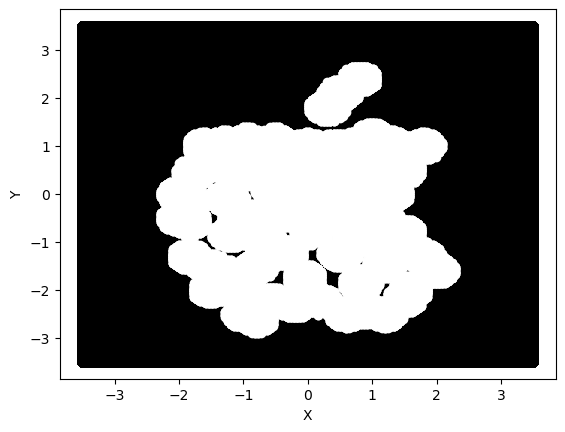

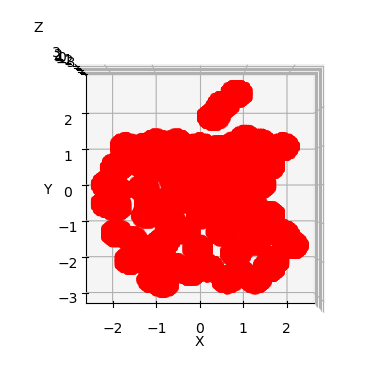

In [27]:
plot_shape_and_union(final_parameters)

/tmp/ipykernel_1381460/4286648845.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  parameters = torch.tensor(parameters, dtype=torch.float32, requires_grad=True)


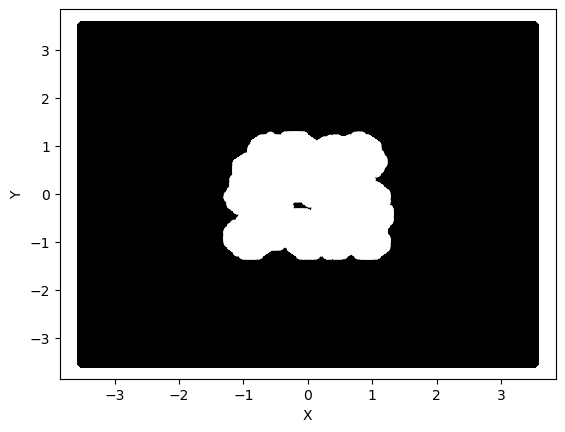

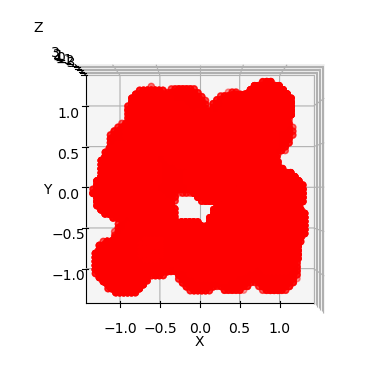

In [29]:
# option1
torch.manual_seed(0)
n = 55
x = torch.distributions.Uniform(-1, 1).sample((n, 1))
y = torch.distributions.Uniform(-1, 1).sample((n, 1))
z = torch.distributions.Uniform(-3, 3).sample((n, 1))
theta_x = torch.zeros(n, 1)
theta_y = torch.zeros(n, 1)
theta_z = torch.zeros(n, 1)
parameters = torch.concatenate((x, y, z, theta_x, theta_y, theta_z), axis=1)
parameters = torch.tensor(parameters, dtype=torch.float32, requires_grad=True)

plot_shape_and_union(parameters)

In [ ]:
# initial_parameters = torch.tensor([[0.5,0,0,0,0,0], 
#                         [3,2,0,0,0,0], 
#                         [3,1.5,0,0,0,0], 
#                         [2.5,3.5,2,0,0,0], 
#                         [2,3.5,2,0,0,0], 
#                         [0,3.5,-3,0,0,0], # insitially: ,
#                         [1.5,2.5,-2,0,0,0], #   initially: 
#                         [1,1,2,0,0,0], 
#                         [1.5,1.5,2,0,0,0], 
#                         [1.7,1.5,2.2,0,0,0]], 
#                         requires_grad=True)

# initialize parameters of size nx3 where the first column is x, second column is y and third column is z, -2<=x<=1.5, -3<=y<=1, -3<=z<=3, and angles are 0
# Randomly initialize parameters within the specified ranges
n = 50
# x = torch.distributions.Uniform(-1, 1).sample((n, 1))
# y = torch.distributions.Uniform(-1, 1).sample((n, 1))
# z = torch.distributions.Uniform(-3, 3).sample((n, 1))
x = torch.distributions.Uniform(-2.5, 2).sample((n, 1))
y = torch.distributions.Uniform(-3, 1.5).sample((n, 1))
z = torch.distributions.Uniform(-3, 3).sample((n, 1))
# theta_x = torch.distributions.Uniform(0, 360).sample((n, 1))
# theta_y = torch.distributions.Uniform(0, 360).sample((n, 1))
# theta_z = torch.distributions.Uniform(0, 360).sample((n, 1))

# x = torch.linspace(-3, 3, n).reshape(n, 1)
# y = torch.linspace(-3, 3, n).reshape(n, 1)
# z = torch.linspace(-3, 3, n).reshape(n, 1)
theta_x = torch.zeros(n, 1)
theta_y = torch.zeros(n, 1)
theta_z = torch.zeros(n, 1)

# Concatenate the columns to create the nx6 parameter matrix
initial_parameters = torch.concatenate((x, y, z, theta_x, theta_y, theta_z), axis=1)
initial_parameters = torch.tensor(initial_parameters, requires_grad=True)

# initial_parameters = torch.tensor([[0.5,0.5,0,0,0,0], [3,2,0,0,0,0], [2,1,0,0,0,0], [2.5,2,2,0,0,0], [2,2,2,0,0,0], [0.5,3.5,-3,0,0,0], [1.5,2,-2,0,0,0], [1,1,2,0,0,0], [1.5,1.5,2,0,0,0], [1.7,1.5,2.2,0,0,0]], requires_grad=True)
# final_parameters = torch.tensor([[ 0.4208, -0.1898,  0.7373,  0.0000,  0.0000,  0.0000],
#         [ 2.4516,  2.0327,  0.6215,  0.0000,  0.0000,  0.0000],
#         [ 3.0787,  1.1999, -0.5315,  0.0000,  0.0000,  0.0000], # initially: ,
#         [ 3.0493,  3.4845,  2.1202,  0.0000,  0.0000,  0.0000],
#         [ 1.4307,  3.8818,  1.3518,  0.0000,  0.0000,  0.0000],
#         [-0.2050,  3.2600, -3.0022,  0.0000,  0.0000,  0.0000], # initially: ,
#         [ 1.6349,  2.6517, -2.0433,  0.0000,  0.0000,  0.0000], # initially: ,
#         [ 0.8115,  1.4215,  2.8483,  0.0000,  0.0000,  0.0000],
#         [ 0.8949,  2.1688,  1.3263,  0.0000,  0.0000,  0.0000],
#         [ 1.4354,  1.8409,  3.0717,  0.0000,  0.0000,  0.0000]],
#        requires_grad=True)
# final_parameters = torch.tensor([[0.9,  3.2, -0.5843,  0.0000,  0.0000,  0.0000],
#         [ 2.1045,  2.3033, -1.4470,  0.0000,  0.0000,  0.0000],
#         [ 2.3518,  1.9407,  0.5938,  0.0000,  0.0000,  0.0000],
#         [ 1.6866,  2.5325,  1.7552,  0.0000,  0.0000,  0.0000],
#         [ 1.9019,  1.8853,  2.5356,  0.0000,  0.0000,  0.0000],
#         [ 0.9019,  3.1699, -2.7858,  0.0000,  0.0000,  0.0000],
#         [ 0.9041,  2.6803, -1.6797,  0.0000,  0.0000,  0.0000],
#         [ 0.8051,  1.1756,  1.6241,  0.0000,  0.0000,  0.0000],
#         [ 0.8665,  2.2409,  1.1161,  0.0000,  0.0000,  0.0000],
#         [ 1.2943,  1.5964,  3.7504,  0.0000,  0.0000,  0.0000]],
#        requires_grad=True)
# final_parameters = parameters
# plot_shape(apple)
# plot_shape_and_union(initial_parameters)
# plot_shape_and_union(final_parameters)
plot_shape_and_union(parameters)
parameters

In [ ]:
parameters

In [ ]:
initial_parameters

In [ ]:
print(parameters)

In [ ]:
print(parameters)

In [ ]:
print(parameters)
parameters = [[0.5,0,0,0,0,0], [3,2,0,0,0,0], [3,1.5,0,0,0,0], [2.5,3.5,2,0,0,0], [2,3.5,2,0,0,0]]

In [ ]:
print(parameters)
parameters = [[0.5,0,0,0,0,0], [3,2,0,0,0,0], [3,1.5,0,0,0,0], [2.5,3.5,2,0,0,0], [2,3.5,2,0,0,0], [0,3.5,-3,0,0,0], [1.5,2.5,-2,0,0,0], [1,1,2,0,0,0], [1.5,1.5,2,0,0,0], [1.7,1.5,2.2,0,0,0]]

In [ ]:
print(parameters)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters to visualize
param1_values = np.linspace(-5, 5, 100)
param2_values = np.linspace(-5, 5, 100)

# Create a grid of parameter values
param1_grid, param2_grid = np.meshgrid(param1_values, param2_values)

# Calculate the loss for each parameter combination (simplified example)
def loss_function(param1, param2):
    return param1 ** 2 + param2 ** 2

loss_grid = loss_function(param1_grid, param2_grid)

# Create a contour plot of the loss landscape
plt.contourf(param1_grid, param2_grid, loss_grid, levels=20, cmap="viridis")
plt.colorbar()

# Simulate optimization trajectory (simplified example)
trajectory_param1 = np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4])
trajectory_param2 = np.array([3, 2, 1, 0, -1, -2, -3, -4, -5])

plt.plot(trajectory_param1, trajectory_param2, marker="o", color="red")

plt.xlabel("Parameter 1")
plt.ylabel("Parameter 2")
plt.title("Loss Landscape and Optimization Trajectory")

plt.show()


---

---

---

---

In [ ]:
# def sdScene(parameters):
#     '''
#     input:
#     parameters: num_shapesx6 tensor of parameters for the num_shapes shapes in the scene

#     return:
#     final_signed_distances: list of signed distances having shape (num_shapes, no_points)
#     '''
#     final_signed_distances = []
#     num_shapes = parameters.shape[0]

#     # sphere 0
#     r=0.4
#     center = parameters[0, 0:3]
#     angles = parameters[0, 3:6]
#     sphere1_signed_distances = sdf_sphere(reshaped_tensor, r, center, angles)
#     final_signed_distances.append(sphere1_signed_distances)

#     # sphere 1
#     r=0.4
#     center = parameters[1, 0:3]
#     angles = parameters[1, 3:6]
#     sphere1_signed_distances = sdf_sphere(reshaped_tensor, r, center, angles)
#     final_signed_distances.append(sphere1_signed_distances)
    
#     # sphere 2
#     r=0.4
#     center = parameters[2, 0:3]
#     angles = parameters[2, 3:6]
#     sphere1_signed_distances = sdf_sphere(reshaped_tensor, r, center, angles)
#     final_signed_distances.append(sphere1_signed_distances)
    
#     # sphere 3
#     r=0.4
#     center = parameters[3, 0:3]
#     angles = parameters[3, 3:6]
#     sphere1_signed_distances = sdf_sphere(reshaped_tensor, r, center, angles)
#     final_signed_distances.append(sphere1_signed_distances)

#     # sphere 4
#     r=0.4
#     center = parameters[4, 0:3]
#     angles = parameters[4, 3:6]
#     sphere1_signed_distances = sdf_sphere(reshaped_tensor, r, center, angles)
#     final_signed_distances.append(sphere1_signed_distances)

#     # sphere 5
#     r=0.4
#     center = parameters[5, 0:3]
#     angles = parameters[5, 3:6]
#     sphere1_signed_distances = sdf_sphere(reshaped_tensor, r, center, angles)
#     final_signed_distances.append(sphere1_signed_distances)

#     # sphere 6
#     r=0.4
#     center = parameters[6, 0:3]
#     angles = parameters[6, 3:6]
#     sphere1_signed_distances = sdf_sphere(reshaped_tensor, r, center, angles)
#     final_signed_distances.append(sphere1_signed_distances)

#     # sphere 7
#     r=0.4
#     center = parameters[7, 0:3]
#     angles = parameters[7, 3:6]
#     sphere1_signed_distances = sdf_sphere(reshaped_tensor, r, center, angles)
#     final_signed_distances.append(sphere1_signed_distances)

#     # sphere 8
#     r=0.4
#     center = parameters[8, 0:3]
#     angles = parameters[8, 3:6]
#     sphere1_signed_distances = sdf_sphere(reshaped_tensor, r, center, angles)
#     final_signed_distances.append(sphere1_signed_distances)

#     # sphere 9
#     r=0.4
#     center = parameters[9, 0:3]
#     angles = parameters[9, 3:6]
#     sphere1_signed_distances = sdf_sphere(reshaped_tensor, r, center, angles)
#     final_signed_distances.append(sphere1_signed_distances)


#     # # box 1
#     # b = torch.tensor([0.7, 0.7, 0.7])
#     # center = parameters[5, 0:3]
#     # angles = parameters[5, 3:6]
#     # box1_signed_distances = sdBox(reshaped_tensor, b, center, angles)
#     # final_signed_distances.append(box1_signed_distances)

#     # # sphere 6
#     # r=1
#     # center = parameters[6, 0:3]
#     # angles = parameters[6, 3:6]
#     # sphere1_signed_distances = sdf_sphere(reshaped_tensor, r, center, angles)
#     # final_signed_distances.append(sphere1_signed_distances)

#     # # link 1
#     # le = torch.FloatTensor([0.7])
#     # r1 = torch.FloatTensor([0.375])
#     # r2 = torch.FloatTensor([0.20])
#     # center = parameters[7, 0:3]
#     # angles = parameters[7, 3:6]
#     # link1_signed_distances = sdLink(reshaped_tensor, le, r1, r2, center, angles)
#     # final_signed_distances.append(link1_signed_distances)

#     # # link 2
#     # le = torch.FloatTensor([2])
#     # r1 = torch.FloatTensor([1.5])
#     # r2 = torch.FloatTensor([1])
#     # center = parameters[8, 0:3]
#     # angles = parameters[8, 3:6]
#     # link2_signed_distances = sdLink(reshaped_tensor, le, r1, r2, center, angles)
#     # final_signed_distances.append(link2_signed_distances)

#     stacked_final_signed_distances = torch.stack(final_signed_distances, dim=1)  
#     return num_shapes, stacked_final_signed_distances

# No

In [ ]:
parameters = [[0.5,0,0,0,0,0], [3,2,0,0,0,0], [3,2,0,0,0,0], [3,2,0,0,0,0], [3,2,0,0,0,0]]
parameters = torch.tensor(parameters, dtype=torch.float32, requires_grad=True)
parameters = torch.nn.Parameter(parameters)
# plot_shape(parameters)
optimizer = torch.optim.Adam([parameters], lr=0.01)
parameters.shape

In [ ]:
min_values = torch.min(stacked_final_signed_distances, dim=0)
print("min_values: ", min_values)
max_values = torch.max(stacked_final_signed_distances, dim=0)
print("max_values: ", max_values)
print("(2*torch.abs(max_values.values - min_values.values)): ", (2*torch.abs(max_values.values - min_values.values)))
stacked_final_signed_distances_softmax = (-stacked_final_signed_distances)/(2*torch.abs(max_values.values - min_values.values)) + 0.5

In [ ]:
# Plotting the 3D signed distance function in 2D
f = 0
to_plot = []
for k in range(0, reshaped_tensor.shape[0], axis_num_pts):
    to_plot.append(stacked_final_signed_distances_softmax[k:k+axis_num_pts, :].sum())
    
    f+=1
print(to_plot)
print(sum(to_plot))

In [ ]:
stacked_final_signed_distances_softmax

In [ ]:
def calulate_loss(parameters):
    num_shapes, stacked_final_signed_distances = sdScene(parameters)
    print("inside calulate_loss, stacked_final_signed_distances.requires_grad: ", stacked_final_signed_distances.requires_grad)
    # Intersection Loss
    intersection_loss = 0
    intersection_mat = [[None for _ in range(num_shapes)] for _ in range(num_shapes)] # creating empty list of lists of size num_shapes x num_shape
    
    for i in range(num_shapes):
        for j in range(i+1, num_shapes):
            intersection_mat[i][j] = torch.max(stacked_final_signed_distances[:, i], stacked_final_signed_distances[:, j])
            intersection_loss += torch.sum(intersection_mat[i][j][intersection_mat[i][j] <= 0])

    intersection_loss = - intersection_loss/num_shapes
    print('Intersection Loss: ', intersection_loss)
    
    # Projection Loss
    projection_loss = 0
    # projection_loss = torch.square(project_union_sdf_new3(stacked_final_signed_distances.clone().detach().requires_grad_(True))[:, 2].clone().detach().requires_grad_(True) - inside).sum()
    print("inside calulate_loss, stacked_final_signed_distances.requires_grad 2: ", stacked_final_signed_distances.requires_grad)
    print("inside calulate_loss, projection_loss.requires_grad: ", stacked_final_signed_distances.requires_grad)
    print('Projection Loss: ', projection_loss, '\n')

    # Total Loss
    loss = intersection_loss + projection_loss
    # loss = projection_loss
    return loss.float()
    # return projection_loss

In [ ]:
def project_union_sdf_new3(stacked_final_signed_distances):
    '''
    input:
    final_signed_distances: tensor of shape (num_points, num_shapes)

    returns:
    point_xy_union: (n2d x 3) whose 3rd column is 1 if the point is inside the union, 0 otherwise
    '''
    i = 0
    # print("in project_union_sdf_new3, stacked_final_signed_distances.requires_grad: ", stacked_final_signed_distances.requires_grad)
    # print("in project_union_sdf_new3, stacked_final_signed_distances[i:i+axis_num_pts, :].shape: ", stacked_final_signed_distances[i:i+axis_num_pts, :].shape)
    # print("in project_union_sdf_new3, torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]): ", torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]))
    
    # point_xy_union_1d = point_xy_union_2d.sum(dim=1)
    # point_xy_union_1d.requires_grad_(True)

    point_xy_union_1d = torch.zeros(axis_num_pts*axis_num_pts, dtype=torch.float32, requires_grad=True)
    # point_xy_union_1d = torch.zeros(axis_num_pts*axis_num_pts, dtype=torch.float32)
    # point_xy_union_1d_new = point_xy_union_1d*1.0
    j = 0

    stacked_final_signed_distances_softmax = torch.nn.functional.softmax(stacked_final_signed_distances, dim=1)
    for i in range(0, reshaped_tensor.shape[0], axis_num_pts):
        # temp = stacked_final_signed_distances[i:i+axis_num_pts, :]
        # point_xy_union_1d[j] = 1 if (stacked_final_signed_distances[i:i+axis_num_pts, :].min() <= 0) else 0
        # point_xy_union_1d[j] = torch.tensor(1 if (stacked_final_signed_distances[i:i+axis_num_pts, :].min() <= 0) else 0)  # Create a new tensor for the result
        # point_xy_union_1d[j] = torch.tensor(1 if (torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]) <= 0) else 0)  # Create a new tensor for the result
        # point_xy_union_1d[j] = torch.tensor(1.0 if (temp.min() <= 0) else 0.0, requires_grad=True)  # Create a new tensor for the result
        # point_xy_union_1d[j] = 1 if torch.le(stacked_final_signed_distances[i:i+axis_num_pts, :], 0).any() else 0
        # mask = stacked_final_signed_distances[i:i+axis_num_pts, :].min() <= 0
        # mask = temp.min() <= 0
        # print("in project_union_sdf_new3, mask.requires_grad: ", mask.requires_grad)
        # point_xy_union_1d[j] = torch.where(mask, torch.tensor(1), torch.tensor(0))
        # point_xy_union_1d[j] =  torch.sigmoid(torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]))
        # point_xy_union_1d[j] += (1.0 if torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]) <= 0 else 0.0) # Create a new tensor for the result
        # point_xy_union_1d[j] = point_xy_union_1d[j] + (1.0 if torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]) <= 0 else 0.0)
        # point_xy_union_1d[j] += (1.0 if torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]) <= 0 else 0.0)
        point_xy_union_1d_new[j] = (1.0 if torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]) <= 0 else 0.0)
        # point_xy_union_1d += stacked_final_signed_distances_softmax[i:i+axis_num_pts, :]
        j += 1
    # point_xy_union_1d_new.requires_grad_()
    # point_xy_union_1d = point_xy_union_1d_new
    # point_xy_union_1d = torch.tensor(point_xy_union_1d_temp, dtype=torch.float32, requires_grad=True)
    # print("in project_union_sdf_new3, point_xy_union_1d.requires_grad: ", point_xy_union_1d.requires_grad)
    # print("in project_union_sdf_new3, point_xy_union_1d_new.requires_grad: ", point_xy_union_1d_new.requires_grad)
    print("in project_union_sdf_new3, point_xy_union_1d.requires_grad: ", point_xy_union_1d.requires_grad)
    # return point_xy_union_1d
    # return point_xy_union_1d_new
    return point_xy_union_1d

In [ ]:
# for GPT
parameters = [[4,4,4,0,0,0]]
parameters = torch.tensor(parameters, dtype=torch.float32, requires_grad=True)
parameters = torch.nn.Parameter(parameters)
plot_shape(parameters)
optimizer = torch.optim.Adam([parameters], lr=0.01)
stacked_final_signed_distances_softmax = torch.nn.functional.softmax(stacked_final_signed_distances, dim=1)

for i in range(10):
    optimizer.zero_grad()
    num_shapes, stacked_final_signed_distances = sdScene(parameters)
    loss = 0
    f = 0
    for k in range(0, reshaped_tensor.shape[0], axis_num_pts):
        loss += (stacked_final_signed_distances_softmax[k:k+axis_num_pts, :] - inside[f]).pow(2).sum()
        f+=1

    loss.backward()
    # loss.backward(retain_graph=True)

    print('Gradients:')
    if parameters.grad is not None:
        print(parameters.grad.norm(2).item())

    print("Gradient before update:", parameters.grad)
    optimizer.step()
    print("Gradient after update:", parameters.grad)
    if(i%2 == 0):
        print('Total Loss: ', loss)

---

In [ ]:
def project_union_sdf(stacked_final_signed_distances):
    '''
    input:
    final_signed_distances: tensor of shape (num_points, num_shapes)

    returns:
    point_xy_union: (n2d x 3) whose 3rd column is 1 if the point is inside the union, 0 otherwise

    stacked_final_signed_distances: (no_points)x(no_shapes)
    union_sdf: (no_points)x1
    reshaped_tensor_union: (no_points)x4
    point_xy_union: (no_points)x3
    '''
    union_sdf = torch.min(stacked_final_signed_distances, dim=1)[0]
    # print("torch.min(stacked_final_signed_distances, dim=1).shape: ", torch.min(stacked_final_signed_distances, dim=1)[0])
    # print("union_sdf shape:", union_sdf.shape)

    reshaped_tensor_union = torch.cat([reshaped_tensor, union_sdf.reshape(reshaped_tensor.shape[0], 1)], dim=1)
    # print("reshaped_tensor_union shape:", reshaped_tensor_union.shape)
    point_xy_union = torch.cat([point_xy, torch.zeros(point_xy.shape[0], 1)], dim=1)

    j = 0
    for i in range(0, reshaped_tensor_union.shape[0], axis_num_pts):
        point_xy_union[j, 2] = 1 if (reshaped_tensor_union[i:i+axis_num_pts, 3].min(dim=0)[0] <= 0) else 0
        j += 1
    return point_xy_union

In [ ]:
def project_union_sdf_new(stacked_final_signed_distances):
    '''
    input:
    final_signed_distances: tensor of shape (num_points, num_shapes)

    returns:
    point_xy_union: (n2d x 3) whose 3rd column is 1 if the point is inside the union, 0 otherwise

    stacked_final_signed_distances: (no_points)x(no_shapes)
    union_sdf: (no_points)x1
    reshaped_tensor_union: (no_points)x4
    point_xy_union: (no_points)x3
    '''
    # union_sdf = torch.min(stacked_final_signed_distances, dim=1)[0]
    # print("torch.min(stacked_final_signed_distances, dim=1).shape: ", torch.min(stacked_final_signed_distances, dim=1)[0])
    # print("union_sdf shape:", union_sdf.shape)

    # reshaped_tensor_union = torch.cat([reshaped_tensor, union_sdf.reshape(reshaped_tensor.shape[0], 1)], dim=1)
    # print("reshaped_tensor_union shape:", reshaped_tensor_union.shape)
    # point_xy_union = torch.cat([point_xy, torch.zeros(point_xy.shape[0], 1)], dim=1)

    j = 0
    for i in range(0, reshaped_tensor.shape[0], axis_num_pts):
        # point_xy_union[j, 2] = 1 if (union_sdf[i:i+axis_num_pts].min(dim=0)[0] <= 0) else 0
        point_xy_union[j, 2] = 1 if (stacked_final_signed_distances[i:i+axis_num_pts, :].min() <= 0) else 0
        j += 1
    return point_xy_union

In [ ]:
def project_union_sdf_new2(stacked_final_signed_distances):
    '''
    input:
    final_signed_distances: tensor of shape (num_points, num_shapes)

    returns:
    point_xy_union: (n2d x 3) whose 3rd column is 1 if the point is inside the union, 0 otherwise

    stacked_final_signed_distances: (no_points)x(no_shapes)
    union_sdf: (no_points)x1
    reshaped_tensor_union: (no_points)x4
    point_xy_union: (no_points)x3
    '''
    point_xy_union_1d = torch.zeros(axis_num_pts*axis_num_pts)
    j = 0
    for i in range(0, reshaped_tensor.shape[0], axis_num_pts):
        point_xy_union_1d[j] = 1 if (stacked_final_signed_distances[i:i+axis_num_pts, :].min() <= 0) else 0
        j += 1
    return point_xy_union_1d

In [ ]:
# Backup
def project_union_sdf_new3(stacked_final_signed_distances):
    '''
    input:
    final_signed_distances: tensor of shape (num_points, num_shapes)

    returns:
    point_xy_union: (n2d x 3) whose 3rd column is 1 if the point is inside the union, 0 otherwise

    stacked_final_signed_distances: (no_points)x(no_shapes)
    union_sdf: (no_points)x1
    reshaped_tensor_union: (no_points)x4
    point_xy_union: (no_points)x3
    '''
    i = 0
    # print("in project_union_sdf_new3, stacked_final_signed_distances.requires_grad: ", stacked_final_signed_distances.requires_grad)
    # print("in project_union_sdf_new3, stacked_final_signed_distances[i:i+axis_num_pts, :].shape: ", stacked_final_signed_distances[i:i+axis_num_pts, :].shape)
    # print("in project_union_sdf_new3, torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]): ", torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]))
    

    # point_xy_union_2d = (torch.min(stacked_final_signed_distances.view(-1, axis_num_pts, stacked_final_signed_distances.shape[1]), dim=1).values <= 0).float()
    # point_xy_union_1d = point_xy_union_2d.sum(dim=1)
    # point_xy_union_1d.requires_grad_(True)



    point_xy_union_1d = torch.zeros(axis_num_pts*axis_num_pts, dtype=torch.float32, requires_grad=True)
    # point_xy_union_1d = torch.zeros(axis_num_pts*axis_num_pts, dtype=torch.float32)
    point_xy_union_1d_new = point_xy_union_1d*1.0
    j = 0
    for i in range(0, reshaped_tensor.shape[0], axis_num_pts):
        # temp = stacked_final_signed_distances[i:i+axis_num_pts, :]
        # point_xy_union_1d[j] = 1 if (stacked_final_signed_distances[i:i+axis_num_pts, :].min() <= 0) else 0
        # point_xy_union_1d[j] = torch.tensor(1 if (stacked_final_signed_distances[i:i+axis_num_pts, :].min() <= 0) else 0)  # Create a new tensor for the result
        # point_xy_union_1d[j] = torch.tensor(1 if (torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]) <= 0) else 0)  # Create a new tensor for the result
        # point_xy_union_1d[j] = torch.tensor(1.0 if (temp.min() <= 0) else 0.0, requires_grad=True)  # Create a new tensor for the result
        # point_xy_union_1d[j] = 1 if torch.le(stacked_final_signed_distances[i:i+axis_num_pts, :], 0).any() else 0
        # mask = stacked_final_signed_distances[i:i+axis_num_pts, :].min() <= 0
        # mask = temp.min() <= 0
        # print("in project_union_sdf_new3, mask.requires_grad: ", mask.requires_grad)
        # point_xy_union_1d[j] = torch.where(mask, torch.tensor(1), torch.tensor(0))
        # point_xy_union_1d[j] =  torch.sigmoid(torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]))
        # point_xy_union_1d[j] += (1.0 if torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]) <= 0 else 0.0) # Create a new tensor for the result
        # point_xy_union_1d[j] = point_xy_union_1d[j] + (1.0 if torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]) <= 0 else 0.0)
        # point_xy_union_1d[j] += (1.0 if torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]) <= 0 else 0.0)
        point_xy_union_1d_new[j] = (1.0 if torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]) <= 0 else 0.0)
        j += 1
    # point_xy_union_1d_new.requires_grad_()
    # point_xy_union_1d = point_xy_union_1d_new
    # point_xy_union_1d = torch.tensor(point_xy_union_1d_temp, dtype=torch.float32, requires_grad=True)
    # print("in project_union_sdf_new3, point_xy_union_1d.requires_grad: ", point_xy_union_1d.requires_grad)
    # print("in project_union_sdf_new3, point_xy_union_1d_new.requires_grad: ", point_xy_union_1d_new.requires_grad)
    print("in project_union_sdf_new3, point_xy_union_1d.requires_grad: ", point_xy_union_1d.requires_grad)
    # return point_xy_union_1d
    return point_xy_union_1d_new

In [ ]:
def project_union_sdf_new3(stacked_final_signed_distances):
    '''
    input:
    final_signed_distances: tensor of shape (num_points, num_shapes)

    returns:
    point_xy_union: (n2d x 3) whose 3rd column is 1 if the point is inside the union, 0 otherwise
    '''
    i = 0
    # print("in project_union_sdf_new3, stacked_final_signed_distances.requires_grad: ", stacked_final_signed_distances.requires_grad)
    # print("in project_union_sdf_new3, stacked_final_signed_distances[i:i+axis_num_pts, :].shape: ", stacked_final_signed_distances[i:i+axis_num_pts, :].shape)
    # print("in project_union_sdf_new3, torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]): ", torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]))
    
    # point_xy_union_1d = point_xy_union_2d.sum(dim=1)
    # point_xy_union_1d.requires_grad_(True)

    point_xy_union_1d = torch.zeros(axis_num_pts*axis_num_pts, dtype=torch.float32, requires_grad=True)
    # point_xy_union_1d = torch.zeros(axis_num_pts*axis_num_pts, dtype=torch.float32)
    point_xy_union_1d_new = point_xy_union_1d*1.0
    j = 0
    for i in range(0, reshaped_tensor.shape[0], axis_num_pts):
        # temp = stacked_final_signed_distances[i:i+axis_num_pts, :]
        # point_xy_union_1d[j] = 1 if (stacked_final_signed_distances[i:i+axis_num_pts, :].min() <= 0) else 0
        # point_xy_union_1d[j] = torch.tensor(1 if (stacked_final_signed_distances[i:i+axis_num_pts, :].min() <= 0) else 0)  # Create a new tensor for the result
        # point_xy_union_1d[j] = torch.tensor(1 if (torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]) <= 0) else 0)  # Create a new tensor for the result
        # point_xy_union_1d[j] = torch.tensor(1.0 if (temp.min() <= 0) else 0.0, requires_grad=True)  # Create a new tensor for the result
        # point_xy_union_1d[j] = 1 if torch.le(stacked_final_signed_distances[i:i+axis_num_pts, :], 0).any() else 0
        # mask = stacked_final_signed_distances[i:i+axis_num_pts, :].min() <= 0
        # mask = temp.min() <= 0
        # print("in project_union_sdf_new3, mask.requires_grad: ", mask.requires_grad)
        # point_xy_union_1d[j] = torch.where(mask, torch.tensor(1), torch.tensor(0))
        # point_xy_union_1d[j] =  torch.sigmoid(torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]))
        # point_xy_union_1d[j] += (1.0 if torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]) <= 0 else 0.0) # Create a new tensor for the result
        # point_xy_union_1d[j] = point_xy_union_1d[j] + (1.0 if torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]) <= 0 else 0.0)
        # point_xy_union_1d[j] += (1.0 if torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]) <= 0 else 0.0)
        point_xy_union_1d_new[j] = (1.0 if torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]) <= 0 else 0.0)
        j += 1
    # point_xy_union_1d_new.requires_grad_()
    # point_xy_union_1d = point_xy_union_1d_new
    # point_xy_union_1d = torch.tensor(point_xy_union_1d_temp, dtype=torch.float32, requires_grad=True)
    # print("in project_union_sdf_new3, point_xy_union_1d.requires_grad: ", point_xy_union_1d.requires_grad)
    print("in project_union_sdf_new3, point_xy_union_1d_new.requires_grad: ", point_xy_union_1d_new.requires_grad)
    print("in project_union_sdf_new3, point_xy_union_1d.requires_grad: ", point_xy_union_1d.requires_grad)
    # return point_xy_union_1d
    return point_xy_union_1d_new

In [ ]:
# parameters = [[0.5,0.5,0.5,90,90,90], [0.6,0.5,0.5,100,0,10], [-2.5, -1, 2,30,20,-200], [1,2,1,50,180,0], [-1, -2, 1,35,-20,-10], [0, 0, 0,70,80,90]]
parameters = [[0,0,0,0,0,0], [0.3,2,-0.3,0,0,0], [-0.3,-0.3,-0.3,0,0,0], [-3,1,-2,0,0,0], [3,2,0,0,0,0], [2,1,3,0,0,0]]
parameters = torch.tensor(parameters, dtype=torch.float32, requires_grad=True)
parameters = torch.nn.Parameter(parameters)
Criterion = torch.nn.MSELoss()
# plot_intersections(parameters)
# plot_union(parameters)
# plot_shape(parameters)
optimizer = torch.optim.Adam([parameters], lr=0.05)
# optimizer = torch.optim.SGD([parameters], lr=0.05)
# print(parameters.requires_grad)
print("parameters.grad: ", parameters.grad)
for i in range(10):
    optimizer.zero_grad()
    num_shapes, stacked_final_signed_distances = sdScene(parameters)

    # loss = calulate_loss(parameters)
    
    # print("in main loop, stacked_final_signed_distances.requires_grad: ", stacked_final_signed_distances.requires_grad)
    # temp = project_union_sdf_new3(stacked_final_signed_distances)
    # print("in main loop, temp.requires_grad: ", temp.requires_grad)
    # loss = torch.square(project_union_sdf(stacked_final_signed_distances.clone().detach().requires_grad_(True))[:, 2].clone().detach().requires_grad_(True) - inside).sum()
    # loss = torch.square(project_union_sdf(stacked_final_signed_distances)[:, 2] - inside).sum()
    # loss = torch.square(project_union_sdf_new(stacked_final_signed_distances)[:, 2] - inside).sum()
    # loss = torch.square(project_union_sdf_new3(stacked_final_signed_distances) - inside).sum()

    # #------------------------
    # i = 0
    # # point_xy_union_2d = (torch.min(stacked_final_signed_distances.view(-1, axis_num_pts, stacked_final_signed_distances.shape[1]), dim=1).values <= 0).float()
    # # point_xy_union_1d = point_xy_union_2d.sum(dim=1)
    # # point_xy_union_1d.requires_grad_(True)
    # point_xy_union_1d = torch.zeros(axis_num_pts*axis_num_pts, dtype=torch.float32, requires_grad=True)
    # point_xy_union_1d_new = point_xy_union_1d*1.0
    # j = 0
    # for i in range(0, reshaped_tensor.shape[0], axis_num_pts):
    #     point_xy_union_1d_new[j] = (1.0 if torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]) <= 0 else 0.0)
    #     j += 1
    # print("in project_union_sdf_new3, point_xy_union_1d.requires_grad: ", point_xy_union_1d.requires_grad)
    # # return point_xy_union_1d
    # #------------------------


    # loss = Criterion(point_xy_union_1d_new, inside)
    loss = Criterion(project_union_sdf_new3(stacked_final_signed_distances), inside)
    print('Projection Loss: ', loss, '\n')
    
    
    loss.backward()

    print('Gradients:')
    if parameters.grad is not None:
        print(parameters.grad.norm(2).item())

    print("Gradient before update:", parameters.grad)
    optimizer.step()
    print("Gradient after update:", parameters.grad)
    if(i%2 == 0):
        print('Total Loss: ', loss)
        # print(parameters)

# plot_intersections(parameters)
# plot_union(parameters)

In [ ]:
# parameters = [[0.5,0.5,0.5,90,90,90], [0.6,0.5,0.5,100,0,10], [-2.5, -1, 2,30,20,-200], [1,2,1,50,180,0], [-1, -2, 1,35,-20,-10], [0, 0, 0,70,80,90]]
# parameters = [[0,0,0,0,0,0], [0.3,2,-0.3,0,0,0], [-0.3,-0.3,-0.3,0,0,0], [-3,1,-2,0,0,0], [3,2,0,0,0,0], [2,1,3,0,0,0]]
parameters = [[0.5,0,0,0,0,0], [1,3,0,0,0,0], [3,2,0,0,0,0]]
parameters = torch.tensor(parameters, dtype=torch.float32, requires_grad=True)
parameters = torch.nn.Parameter(parameters)
# Criterion = torch.nn.MSELoss()
# plot_intersections(parameters)
# plot_union(parameters)
plot_shape(parameters)
optimizer = torch.optim.Adam([parameters], lr=0.01)
# optimizer = torch.optim.SGD([parameters], lr=0.05)
# print(parameters.requires_grad)
print("parameters.grad: ", parameters.grad) # it will show none as we have not called backward() yet
# print("stacked_final_signed_distances:", stacked_final_signed_distances)

for i in range(10):
    optimizer.zero_grad()
    num_shapes, stacked_final_signed_distances = sdScene(parameters)
    # stacked_final_signed_distances_softmax = torch.nn.functional.softmax(stacked_final_signed_distances, dim=1)
    
    # min_values = torch.min(stacked_final_signed_distances, dim=0)
    # max_values = torch.max(stacked_final_signed_distances, dim=0)
    # stacked_final_signed_distances_softmax = (-stacked_final_signed_distances)/(2*torch.abs(max_values.values - min_values.values)) + 0.5

    stacked_final_signed_distances_softmax = torch.relu(-stacked_final_signed_distances)

    # loss = calulate_loss(parameters)
    
    # print("in main loop, stacked_final_signed_distances.requires_grad: ", stacked_final_signed_distances.requires_grad)
    # temp = project_union_sdf_new3(stacked_final_signed_distances)
    # print("in main loop, temp.requires_grad: ", temp.requires_grad)
    # loss = torch.square(project_union_sdf(stacked_final_signed_distances.clone().detach().requires_grad_(True))[:, 2].clone().detach().requires_grad_(True) - inside).sum()
    # loss = torch.square(project_union_sdf(stacked_final_signed_distances)[:, 2] - inside).sum()
    # loss = torch.square(project_union_sdf_new(stacked_final_signed_distances)[:, 2] - inside).sum()
    # loss = torch.square(project_union_sdf_new3(stacked_final_signed_distances) - inside).sum()

    # #------------------------
    # i = 0
    # # point_xy_union_2d = (torch.min(stacked_final_signed_distances.view(-1, axis_num_pts, stacked_final_signed_distances.shape[1]), dim=1).values <= 0).float()
    # # point_xy_union_1d = point_xy_union_2d.sum(dim=1)
    # # point_xy_union_1d.requires_grad_(True)
    # point_xy_union_1d = torch.zeros(axis_num_pts*axis_num_pts, dtype=torch.float32, requires_grad=True)
    # point_xy_union_1d_new = point_xy_union_1d*1.0
    # j = 0
    # for i in range(0, reshaped_tensor.shape[0], axis_num_pts):
    #     point_xy_union_1d_new[j] = (1.0 if torch.min(stacked_final_signed_distances[i:i+axis_num_pts, :]) <= 0 else 0.0)
    #     j += 1
    # print("in project_union_sdf_new3, point_xy_union_1d.requires_grad: ", point_xy_union_1d.requires_grad)
    # # return point_xy_union_1d
    # #------------------------


    # loss = Criterion(point_xy_union_1d_new, inside)
    # loss = Criterion(project_union_sdf_new3(stacked_final_signed_distances), inside)
    # k = 0
    # print("stacked_final_signed_distances_softmax.shape: ", stacked_final_signed_distances_softmax.shape)
    # print("inside.shape: ", inside.shape)
    loss = 0
    f = 0
    for k in range(0, reshaped_tensor.shape[0], axis_num_pts):
        # print("k: ", k)
        # print("stacked_final_signed_distances_softmax[k, :]", stacked_final_signed_distances_softmax[k, :])
        # print("inside[k]", inside[k])
        # print("loss inside the loop: ", loss)
        loss += (stacked_final_signed_distances_softmax[k:k+axis_num_pts, :].sum()/axis_num_pts - inside[f]).pow(2)
        f+=1

    loss.backward()
    # loss.backward(retain_graph=True)

    print('Gradients:')
    if parameters.grad is not None:
        print(parameters.grad.norm(2).item())

    print("Gradient before update:", parameters.grad.sum())
    # print("optimizer Gradient before update:", optimizer.grad)
    optimizer.step()
    print("Gradient after update:", parameters.grad.sum())
    if(i%2 == 0):
        print('Total Loss: ', loss)
        print(parameters)

# plot_intersections(parameters)
# plot_union(parameters)

In [ ]:
parameters = [[-2,-2,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0], [0,0,0,0,0,0]]
parameters = torch.tensor(parameters, dtype=torch.float32, requires_grad=True)
parameters = torch.nn.Parameter(parameters)
num_shapes, stacked_final_signed_distances = sdScene(parameters)
project_union_sdf_new3(stacked_final_signed_distances)

In [ ]:
a = stacked_final_signed_distances[0:0+axis_num_pts, :].min()
print(a)

In [ ]:
import torch

# Create a tensor and enable gradient tracking
x = torch.tensor([2.0, -3.0, 4.0], requires_grad=True)

# Create a new tensor with the modified value
new_x = x * 1

for i in range(3):
    new_x[i] = (1.0 if new_x[i] <= 0 else 0.0)

# Compute some function using new_x
y = new_x.pow(2).sum()
print(y)
# Perform backpropagation to compute gradients
y.backward()
print(new_x.grad)
# Access the gradients of x
print(x.grad)
